# 一、处理原始数据集

将 kaggle 提供的训练集、测试集压缩文件下载到本地后，进行解压缩。将所有的训练集图片放在 train 文件夹中，测试集的图片都放在 test 文件夹中。

In [1]:
import os
import zipfile
from os.path import isfile, isdir

if isfile("train.zip"):
    if not isdir("train"):
        with zipfile.ZipFile("train.zip","r") as zf:
            zf.extractall()
            zf.close()
if isfile("test.zip"):
    if not isdir("test"):
        with zipfile.ZipFile("test.zip","r") as zf:
            zf.extractall()
            zf.close()
if isdir("train"):
    print("train images num: %d" % len(os.listdir("train")))
if isdir("test"):
    print("test images num: %d" % len(os.listdir("test")))

train images num: 25000
test images num: 12500


Using TensorFlow backend.
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:278: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


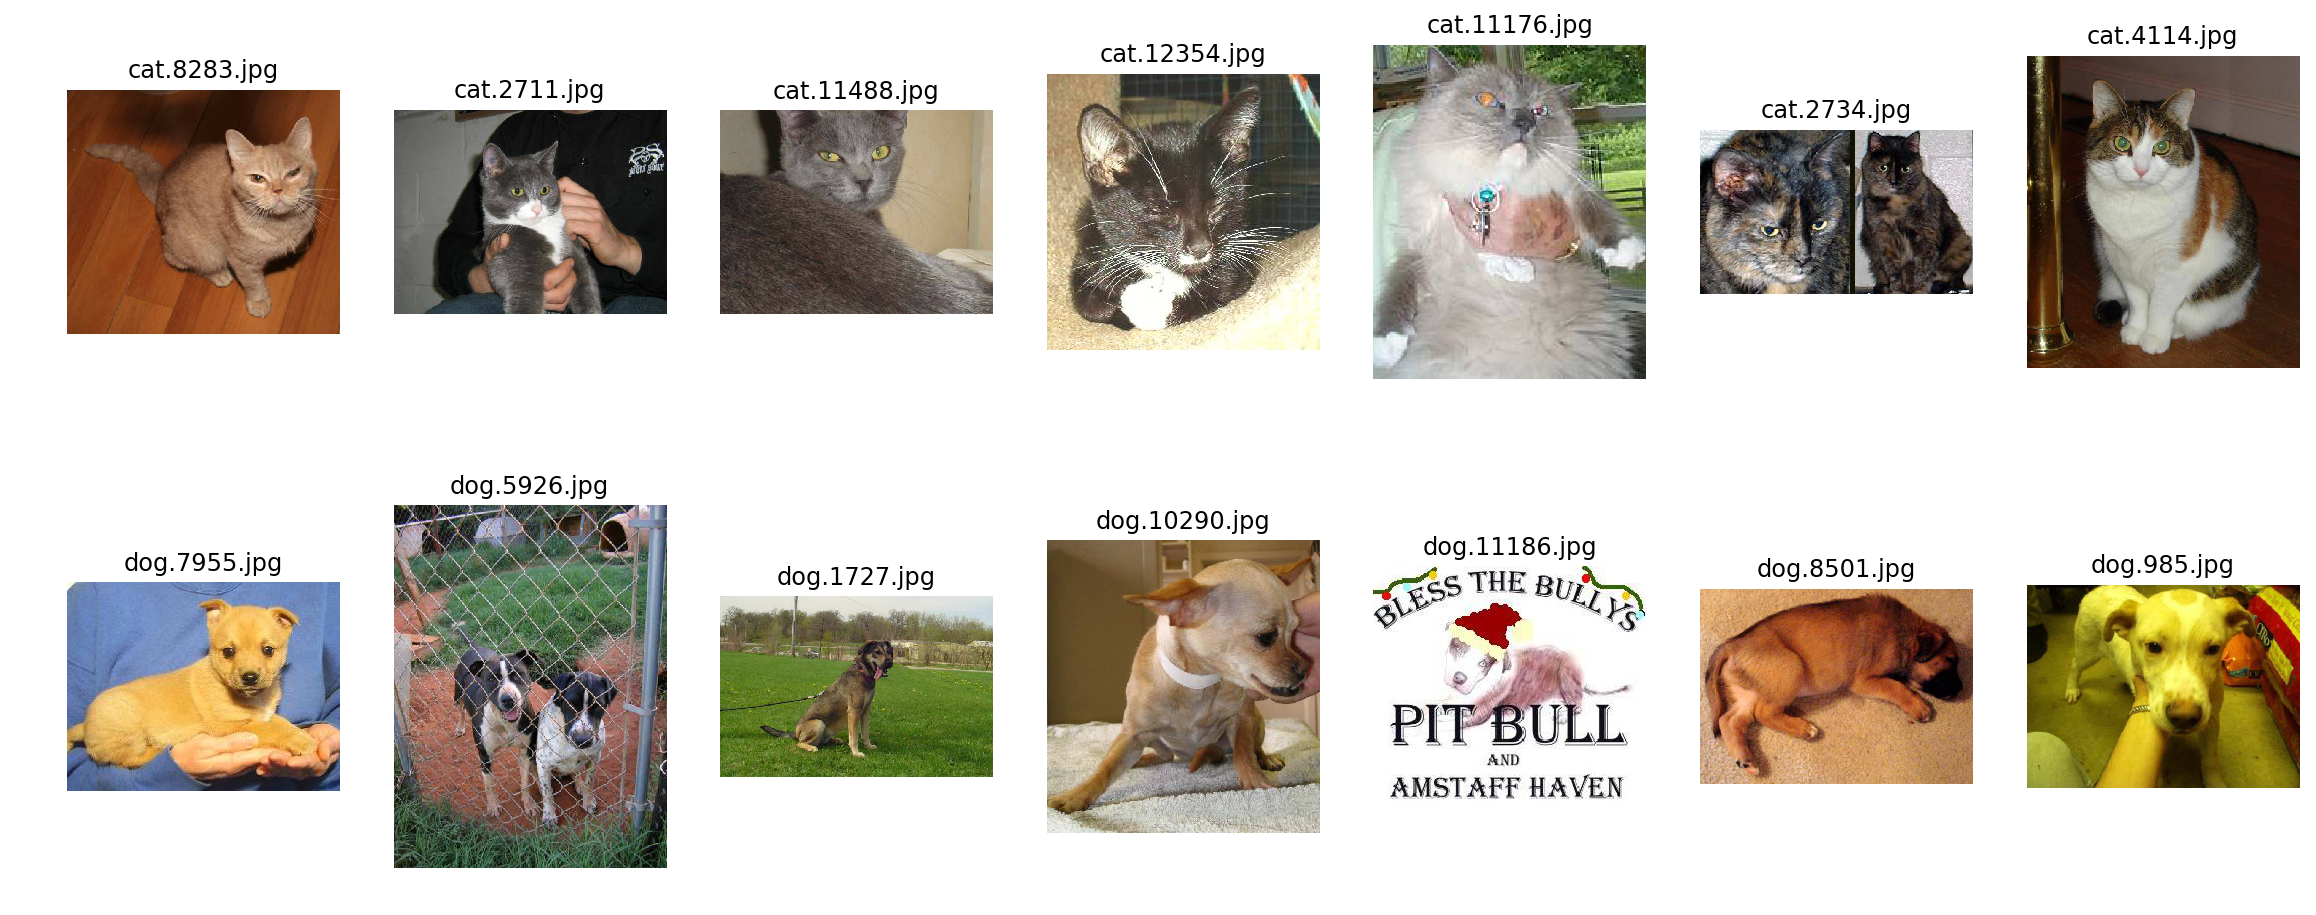

In [2]:
#随机预览几张图片
from keras.preprocessing.image import *
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

fig = plt.figure(figsize=(20,8))
for i in range(14):
    a = fig.add_subplot(2, 7, i+1)
    if i < 7:
        file = "cat.%s.jpg" % np.random.randint(12500)
    else:
        file = "dog.%s.jpg" % np.random.randint(12500)
    a.set_title(file)
    a.axis('off')
    img = load_img("train/"+file)
    a.imshow(img, interpolation="nearest")

In [3]:
import numpy as np
from PIL import Image
from tqdm import tqdm

shape_list = []
for file in tqdm(os.listdir('train')):
    img = Image.open("train/"+file)
    x = img.size
    shape_list.append((x[0], x[1]))

100%|██████████| 25000/25000 [00:01<00:00, 12922.81it/s]


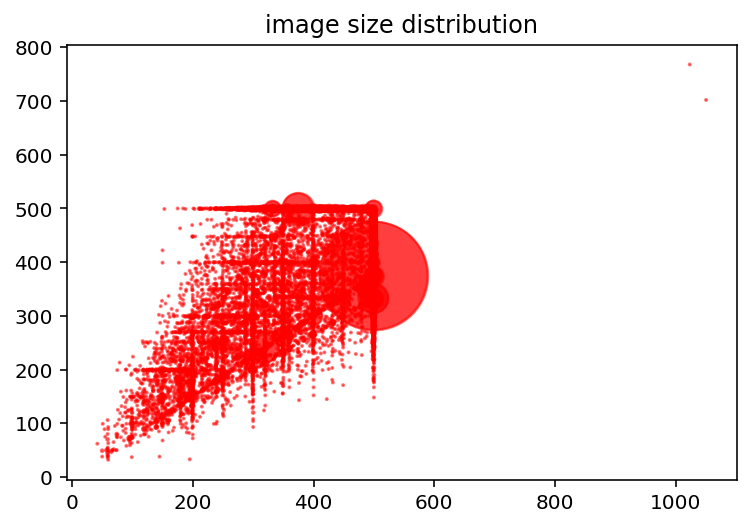

In [4]:
from collections import Counter
import matplotlib.pyplot as plt

shape_collect = Counter(shape_list)

x_w = []
y_h = []
area = []
for k in shape_collect:
    area.append(shape_collect[k])
    x_w.append(k[0])
    y_h.append(k[1])
colors = np.random.rand(len(x_w))
plt.scatter(x_w, y_h, s=area, c='r', alpha=0.5)
plt.title('image size distribution')
plt.show()

In [5]:
tiny_pics, large_pics = [], []
for file in tqdm(os.listdir('train')):
    img = Image.open("train/"+file)
    x = img.size
    if x[0] < 100 and x[1] < 100:
        tiny_pics.append(file)
    elif x[0] > 800:
        large_pics.append(file)
print("tiny pics: %s\n%s" % (len(tiny_pics), tiny_pics))
print("large_pics: %s\n%s" % (len(large_pics), large_pics))

100%|██████████| 25000/25000 [00:01<00:00, 13073.53it/s]

tiny pics: 76
['dog.1381.jpg', 'cat.6614.jpg', 'cat.7703.jpg', 'cat.3739.jpg', 'dog.943.jpg', 'dog.12185.jpg', 'dog.10733.jpg', 'dog.4134.jpg', 'dog.1324.jpg', 'dog.11248.jpg', 'dog.2965.jpg', 'cat.5954.jpg', 'dog.10664.jpg', 'dog.3147.jpg', 'cat.5534.jpg', 'cat.10392.jpg', 'dog.8570.jpg', 'cat.8470.jpg', 'cat.11094.jpg', 'cat.596.jpg', 'cat.8087.jpg', 'dog.7421.jpg', 'dog.7011.jpg', 'cat.5527.jpg', 'dog.7374.jpg', 'dog.9705.jpg', 'cat.7314.jpg', 'dog.9456.jpg', 'cat.7487.jpg', 'cat.2433.jpg', 'dog.9288.jpg', 'cat.4629.jpg', 'dog.11686.jpg', 'dog.10385.jpg', 'cat.11091.jpg', 'dog.7765.jpg', 'dog.10225.jpg', 'dog.7369.jpg', 'cat.1423.jpg', 'cat.3980.jpg', 'dog.3074.jpg', 'cat.8138.jpg', 'dog.8428.jpg', 'cat.4963.jpg', 'cat.6402.jpg', 'cat.3641.jpg', 'dog.2652.jpg', 'dog.296.jpg', 'dog.10747.jpg', 'cat.8504.jpg', 'dog.2188.jpg', 'dog.7772.jpg', 'cat.485.jpg', 'cat.4833.jpg', 'cat.4821.jpg', 'dog.10637.jpg', 'dog.10155.jpg', 'dog.927.jpg', 'dog.8987.jpg', 'dog.630.jpg', 'cat.10107.jpg', '

# 二、整理文件结构
利用 keras 预训练模型筛选出训练集中的异常值。keras 的 ImageDataGenerator 需要重新安排文件结构，最终需要将文件夹结构设置为：

```
data/
    train/
        dogs/
            dog001.jpg
            dog002.jpg
            ...
        cats/
            cat001.jpg
            cat002.jpg
            ...
```

为了避免重复占用磁盘空间，这里采用链接文件夹的方法

In [6]:
import shutil

#训练集分为猫狗两个种类
train_filenames = os.listdir('train')
train_cat = filter(lambda x:x[:3] == 'cat', train_filenames)
train_dog = filter(lambda x:x[:3] == 'dog', train_filenames)

if isdir('train2'):
    shutil.rmtree('train2')
os.makedirs('train2/cat')
os.makedirs('train2/dog')
abspath = os.getcwd()
for cat in train_cat:
    os.symlink(os.path.join(abspath, 'train/' + cat), 'train2/cat/' + cat)
for dog in train_dog:
    os.symlink(os.path.join(abspath, 'train/' + dog), 'train2/dog/' + dog)

#测试集
if isdir('test2'):
    shutil.rmtree('test2')
os.makedirs('test2')
os.symlink(os.path.join(abspath, 'test'), 'test2/test')
print('symlink created.')

symlink created.


# 三、预训练模型输出类别
ImageNet(14,197,122 images, 21841 synsets indexed)是一个非常巨大的数据集，keras 中包含的预训练集就是在这个数据集上训练完成的，输出的结果中包含1000个分类（ https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json ）。 
其中猫和狗的类别如下：
 
 > 狗：151("n02085620", "Chihuahua") ~ 276("n02117135", "hyena")
 >
 > 猫：281("n02123045", "tabby") ~ 287("n02127052", "lynx")

In [7]:
dog_classes = [
     'n02085620','n02085782','n02085936','n02086079'
    ,'n02086240','n02086646','n02086910','n02087046'
    ,'n02087394','n02088094','n02088238','n02088364'
    ,'n02088466','n02088632','n02089078','n02089867'
    ,'n02089973','n02090379','n02090622','n02090721'
    ,'n02091032','n02091134','n02091244','n02091467'
    ,'n02091635','n02091831','n02092002','n02092339'
    ,'n02093256','n02093428','n02093647','n02093754'
    ,'n02093859','n02093991','n02094114','n02094258'
    ,'n02094433','n02095314','n02095570','n02095889'
    ,'n02096051','n02096177','n02096294','n02096437'
    ,'n02096585','n02097047','n02097130','n02097209'
    ,'n02097298','n02097474','n02097658','n02098105'
    ,'n02098286','n02098413','n02099267','n02099429'
    ,'n02099601','n02099712','n02099849','n02100236'
    ,'n02100583','n02100735','n02100877','n02101006'
    ,'n02101388','n02101556','n02102040','n02102177'
    ,'n02102318','n02102480','n02102973','n02104029'
    ,'n02104365','n02105056','n02105162','n02105251'
    ,'n02105412','n02105505','n02105641','n02105855'
    ,'n02106030','n02106166','n02106382','n02106550'
    ,'n02106662','n02107142','n02107312','n02107574'
    ,'n02107683','n02107908','n02108000','n02108089'
    ,'n02108422','n02108551','n02108915','n02109047'
    ,'n02109525','n02109961','n02110063','n02110185'
    ,'n02110341','n02110627','n02110806','n02110958'
    ,'n02111129','n02111277','n02111500','n02111889'
    ,'n02112018','n02112137','n02112350','n02112706'
    ,'n02113023','n02113186','n02113624','n02113712'
    ,'n02113799','n02113978','n02114367','n02114548'
    ,'n02114712','n02114855','n02115641','n02115913'
    ,'n02116738','n02117135']

cat_classes = [
    'n02123045','n02123159','n02123394','n02123597'
    ,'n02124075','n02125311','n02127052']

print("dog_classes: %s" % len(dog_classes))
print("cat_clasees: %s" % len(cat_classes))

dog_classes: 126
cat_clasees: 7


# 四、利用预训练模型检出异常

In [8]:
from keras.models import *
from keras.preprocessing.image import *
from keras.applications import *
from tqdm import tqdm

def checkout_outlier(MODEL, preprocess=None, decode=None,
                     dirs='train2/cat', from_classes=cat_classes, size=(224,224), top=25):
    model_name = MODEL.__name__
    model = MODEL(weights='imagenet')
    result = []
    pbar = tqdm(os.listdir(dirs))
    for file in pbar:
        img = load_img('train/'+file, target_size=size)
        x = img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess(x)
        
        pred = model.predict(x)
        decpred = decode(pred, top = top)
                
        correct = False
        for predicted in enumerate(decpred[0]):
            if predicted[1][0] in from_classes:
                correct = True
                break
        if not correct and file not in result:
            result.append(file)
        
        pbar.set_description('%s checking %s' % (model_name, file))
    return result

cat 文件夹中被预测为不是猫的文件：

In [9]:

cat_outlier1 = checkout_outlier(ResNet50, 
                               preprocess=resnet50.preprocess_input,
                               decode=resnet50.decode_predictions)
cat_outlier2 = checkout_outlier(InceptionV3,
                               preprocess=inception_v3.preprocess_input,
                               decode=inception_v3.decode_predictions,
                               size=(299,299))
#cat_outlier = [v for v in cat_outlier1 if v in cat_outlier2]
cat_outlier = list(set(cat_outlier1) & set(cat_outlier2))
print('cat outlier num: %d' % len(cat_outlier))
print(cat_outlier)

102858752/102853048 [==============================] - 1s 0us/step


  0%|          | 0/12500 [00:00<?, ?it/s]

40960/35363 [==================================] - 0s 0us/step


ResNet50 checking cat.8408.jpg: 100%|██████████| 12500/12500 [04:42<00:00, 44.31it/s] 


96116736/96112376 [==============================] - 1s 0us/step


InceptionV3 checking cat.8408.jpg: 100%|██████████| 12500/12500 [04:56<00:00, 42.18it/s] 

cat outlier num: 101
['cat.3766.jpg', 'cat.3637.jpg', 'cat.169.jpg', 'cat.7671.jpg', 'cat.372.jpg', 'cat.8470.jpg', 'cat.6345.jpg', 'cat.9983.jpg', 'cat.7263.jpg', 'cat.7487.jpg', 'cat.12227.jpg', 'cat.2337.jpg', 'cat.7377.jpg', 'cat.3216.jpg', 'cat.4965.jpg', 'cat.7429.jpg', 'cat.2150.jpg', 'cat.8487.jpg', 'cat.9513.jpg', 'cat.5820.jpg', 'cat.12493.jpg', 'cat.3105.jpg', 'cat.8383.jpg', 'cat.3399.jpg', 'cat.9090.jpg', 'cat.10029.jpg', 'cat.12272.jpg', 'cat.12424.jpg', 'cat.7920.jpg', 'cat.4833.jpg', 'cat.4688.jpg', 'cat.9456.jpg', 'cat.11607.jpg', 'cat.6703.jpg', 'cat.7411.jpg', 'cat.5583.jpg', 'cat.10700.jpg', 'cat.3658.jpg', 'cat.9110.jpg', 'cat.5355.jpg', 'cat.6402.jpg', 'cat.4076.jpg', 'cat.10532.jpg', 'cat.11039.jpg', 'cat.7291.jpg', 'cat.10864.jpg', 'cat.11222.jpg', 'cat.6442.jpg', 'cat.5418.jpg', 'cat.9947.jpg', 'cat.7009.jpg', 'cat.3004.jpg', 'cat.11879.jpg', 'cat.8921.jpg', 'cat.2939.jpg', 'cat.7564.jpg', 'cat.5324.jpg', 'cat.12431.jpg', 'cat.8576.jpg', 'cat.9171.jpg', 'cat.48

dog 文件夹中被预测为不是狗的文件：

In [10]:
dog_outlier1 = checkout_outlier(ResNet50, dirs='train2/dog', from_classes=dog_classes,
                               preprocess=resnet50.preprocess_input,
                               decode=resnet50.decode_predictions)
dog_outlier2 = checkout_outlier(InceptionV3,dirs='train2/dog', from_classes=dog_classes,
                               preprocess=inception_v3.preprocess_input,
                               decode=inception_v3.decode_predictions,
                               size=(299,299))
#dog_outlier = [v for v in dog_outlier1 if v in dog_outlier2]
dog_outlier = list(set(dog_outlier1) & set(dog_outlier2))
print('dog outlier num: %d' % len(dog_outlier))
print(dog_outlier)

InceptionV3 checking dog.8217.jpg: 100%|██████████| 12500/12500 [05:02<00:00, 41.36it/s] 

dog outlier num: 18
['dog.4507.jpg', 'dog.10161.jpg', 'dog.1773.jpg', 'dog.11299.jpg', 'dog.1259.jpg', 'dog.1194.jpg', 'dog.9517.jpg', 'dog.2614.jpg', 'dog.8736.jpg', 'dog.12376.jpg', 'dog.10237.jpg', 'dog.4367.jpg', 'dog.5604.jpg', 'dog.6475.jpg', 'dog.10190.jpg', 'dog.2422.jpg', 'dog.10801.jpg', 'dog.1895.jpg']


# 五、猫狗异常值预览：

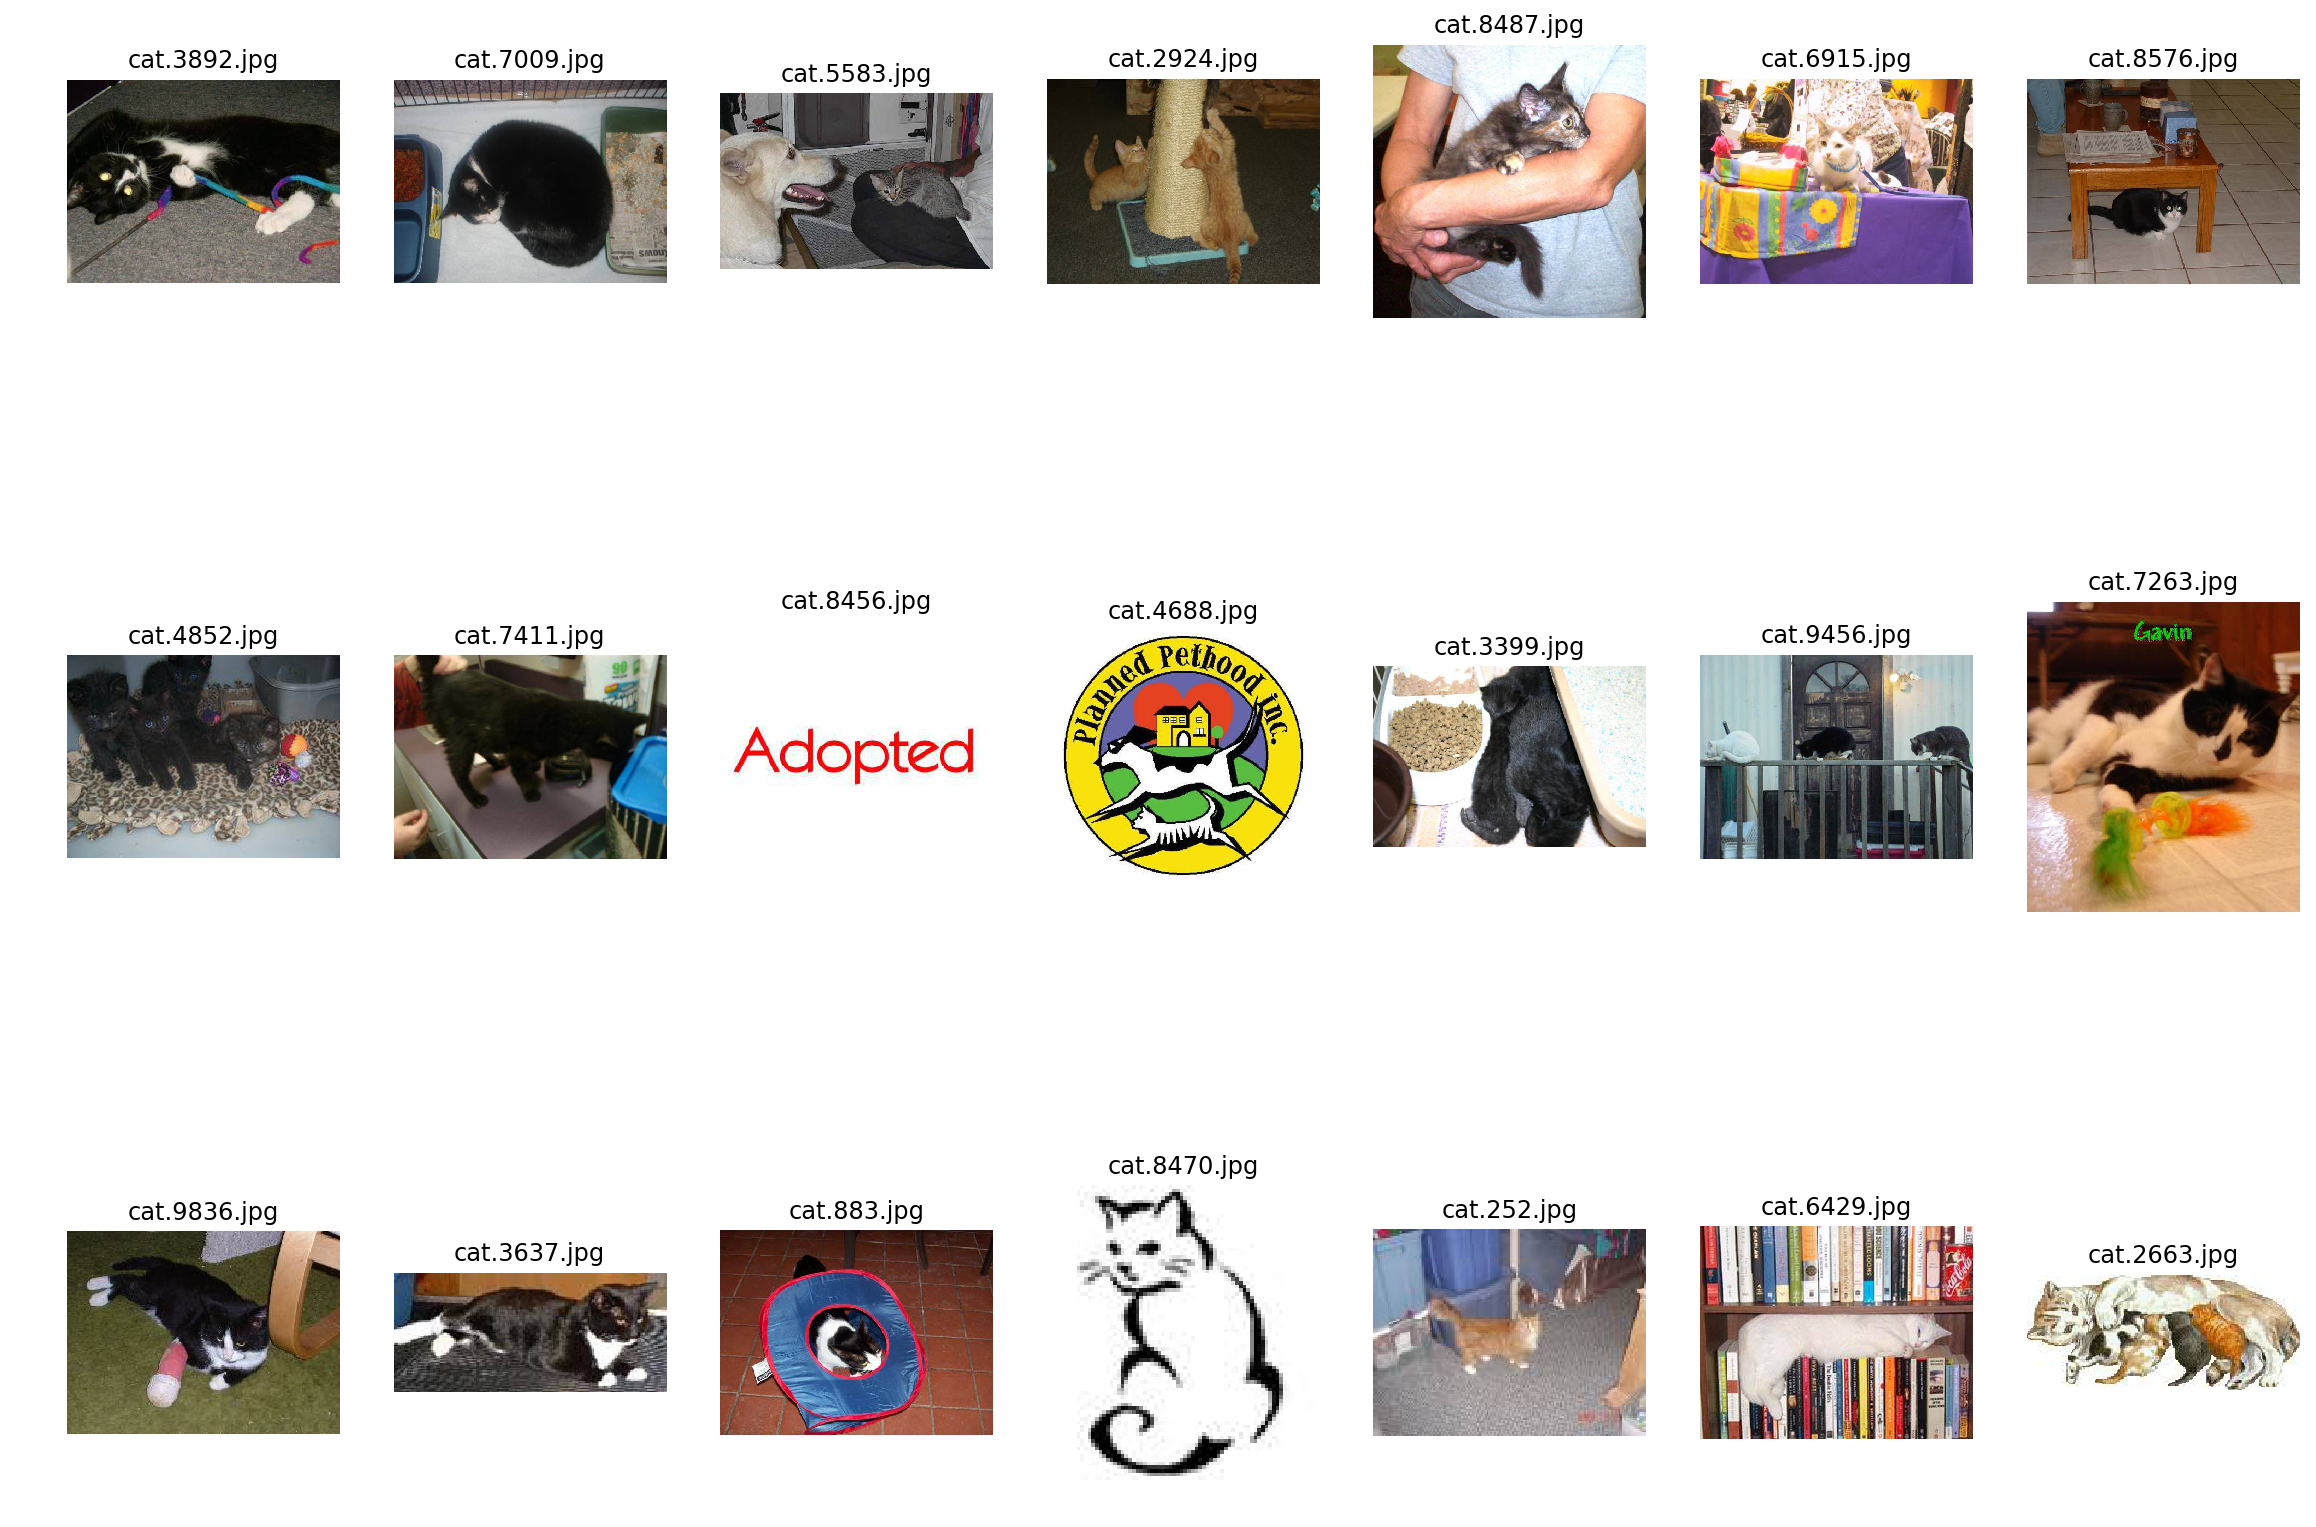

In [12]:
import random
fig = plt.figure(figsize=(20,15))
for i, name in enumerate(random.sample(cat_outlier, 21)):
    a = fig.add_subplot(3, 7, i+1)
    a.set_title(name)
    a.axis('off')
    img = load_img("train/"+name)
    a.imshow(img, interpolation="nearest")

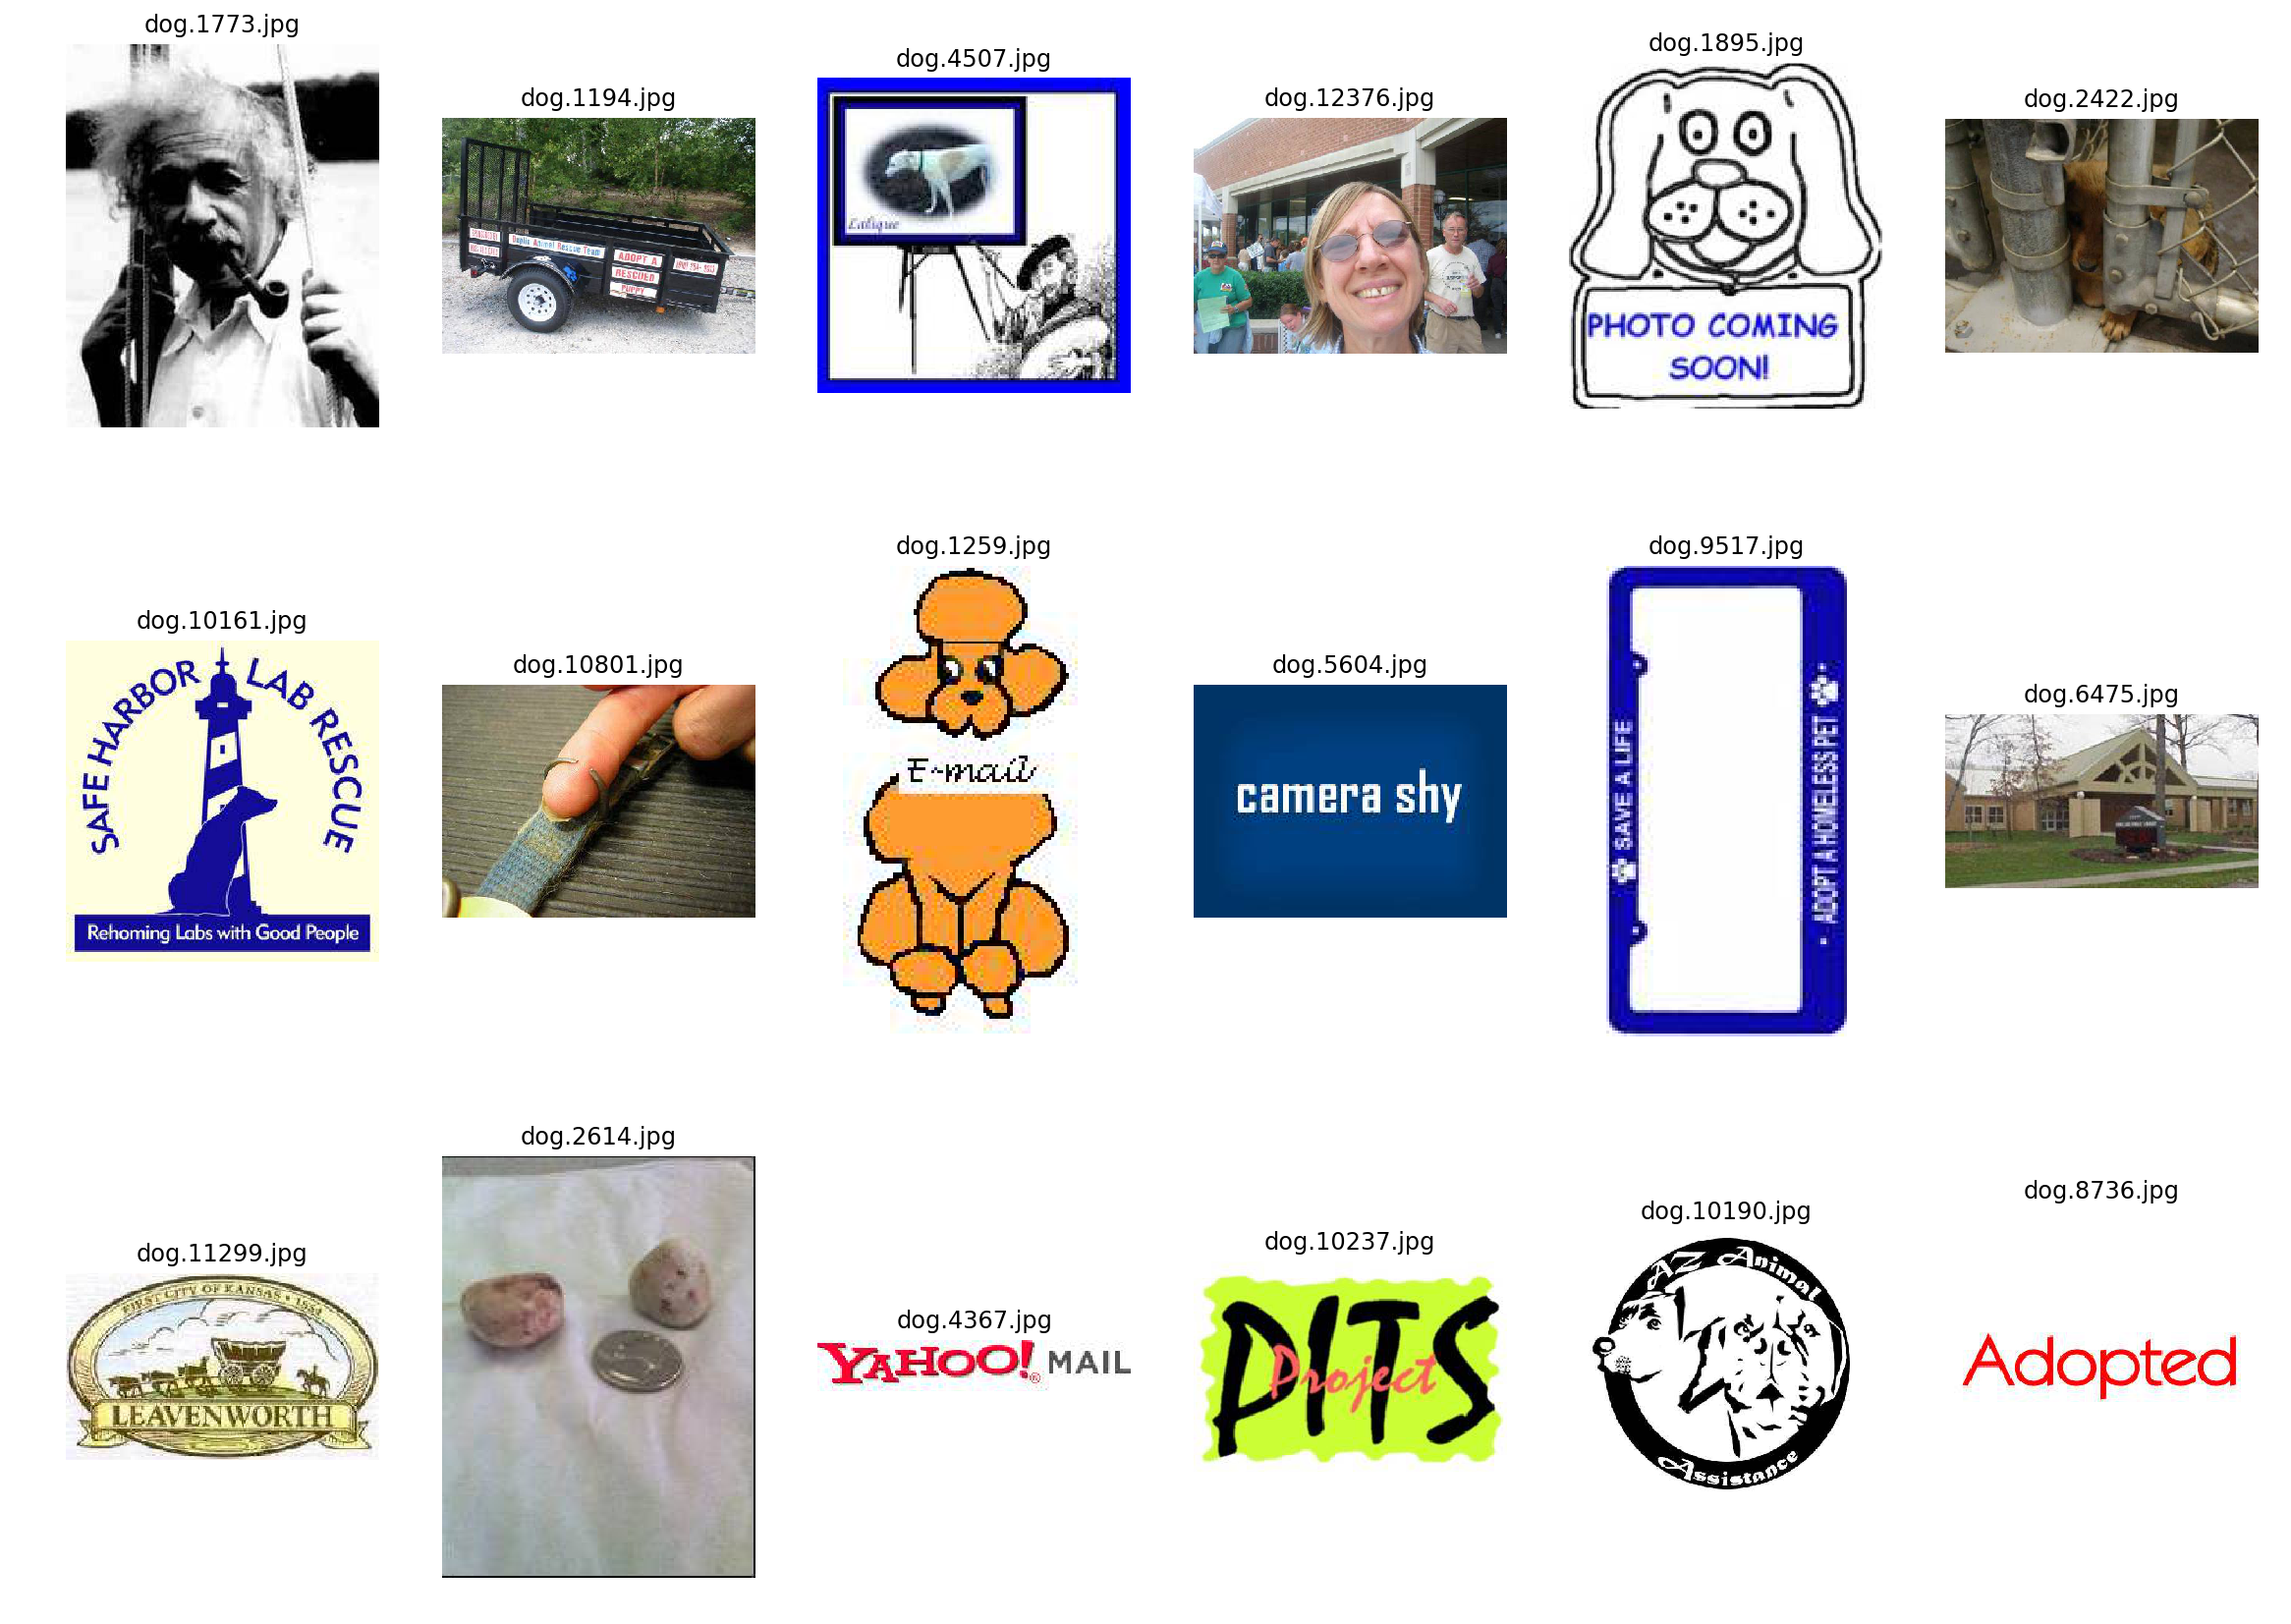

In [14]:
fig = plt.figure(figsize=(20,15))
for i, name in enumerate(random.sample(dog_outlier, 18)):
    a = fig.add_subplot(3, 6, i+1)
    a.set_title(name)
    a.axis('off')
    img = load_img("train/"+name)
    a.imshow(img, interpolation="nearest")

In [15]:
#去掉异常值后的训练集，重新进行文件链接
if isdir('train3'):
    shutil.rmtree('train3')
os.makedirs('train3/cat')
os.makedirs('train3/dog')
abspath = os.getcwd()

cat_plus = cat_outlier + tiny_pics
dog_plus = dog_outlier + tiny_pics
for cat in os.listdir('train2/cat'):
    if cat not in cat_plus:
        os.symlink(os.path.join(abspath, 'train/'+cat), 'train3/cat/'+cat)
for dog in os.listdir('train2/dog'):
    if dog not in dog_plus:
        os.symlink(os.path.join(abspath, 'train/'+dog), 'train3/dog/'+dog)

print('symlink created.')
print('train3/cat file nums: %d' % len(os.listdir('train3/cat')))
print('train3/dog file nums: %d' % len(os.listdir("train3/dog")))

symlink created.
train3/cat file nums: 12369
train3/dog file nums: 12440


In [16]:
np.save('tiny_pics.npy', tiny_pics)
np.save('cat_outlier.npy', cat_outlier)
np.save('dog_outlier.npy', dog_outlier)
print('saved.')

saved.


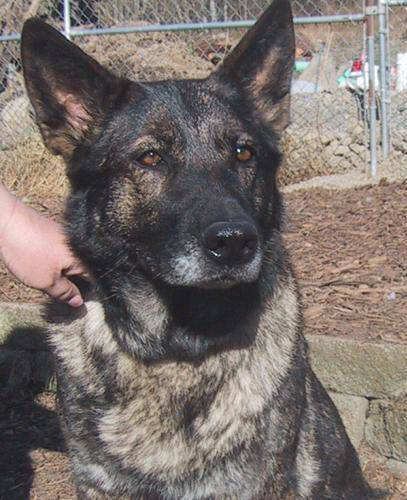

In [17]:
Image.open('train3/dog/dog.9220.jpg')